# Цель

Построение различных вариантов кластеризаций и интерпретация результатов. 

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import re
import time
import datetime

# Датасет

При прогнозировании цен на акции вы собираете данные за некоторый период времени - день, неделю, месяц и т.д. 
Но вы не можете использовать данные за период времени до следующего приращения периода времени. 
Например, предположим, что вы собираете данные ежедневно. По окончании понедельника у вас есть все данные за этот день. Однако вы можете инвестировать в понедельник, потому что вы не получите данные до конца дня. Вы можете использовать данные с понедельника, чтобы инвестировать во вторник.

В нашем исследовании каждая запись (строка) - это данные за неделю. Каждая запись также имеет процент возврата, который акции имеют на следующей неделе (percent_change_next_weeks_price). В идеале вы хотите определить, какая акция будет приносить наибольшую доходность на следующей неделе. Это может помочь вам обучить и проверить ваш алгоритм.

Некоторые из этих атрибутов могут не использоваться в вашем исследовании. Первоначально они были добавлены в нашу базу данных для выполнения расчетов. (Brown, Pelosi & Dirska, 2013) использовали percent_change_price, percent_change_volume_over_last_wk, days_to_next_dividend и percent_return_next_dividend. Мы оставили другие атрибуты в наборе данных на случай, если вы захотите использовать любой из них. Конечно, вы хотите, чтобы максимизировать это percent_change_next_weeks_price.

Информация о признаках:

    `quarter`: годовой квартал (1 = январь-март; 2 = апрель - июнь).
    `stock`: символ акции
    `date`: последний рабочий день недели (обычно это пятница)
    `open`: цена акции в начале недели
    `high`: самая высокая цена акции в течение недели
    `low`: самая низкая цена акции в течение недели
    `close`: цена акции в конце недели
    `volume`: количество акций, которые торговались в течение недели
    `cent_change_price`: процентное изменение цены в течение недели
    `cent_chagne_volume_over_last_wek`: процентное изменение количества акций, которые торговались за эту неделю по сравнению с предыдущей неделей
    `previous_weeks_volume`: количество акций, которые торговались на предыдущей неделе
    `next_weeks_open`: цена открытия акции на следующей неделе
    `next_weeks_close`: цена закрытия акции на следующей неделе
    `cent_change_next_weeks_price`: процентное изменение цены акции в следующую неделю
    `days_to_next_dividend`: количество дней до следующих дивидендов
    `cent_return_next_dividend`: процент прибыли на следующие дивиденды

https://archive.ics.uci.edu/ml/datasets/Dow+Jones+Index

# EDA

## 1. Целевая переменная

Считаем наш датасет из файла и выведем 8 строк.

In [272]:
df = pd.read_csv('data/dow_jones_index.data')
df.head(8)

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
0,1,AA,1/7/2011,$15.82,$16.72,$15.78,$16.42,239655616,3.792670,NaN,NaN,$16.71,$15.97,-4.428490,26,0.182704
1,1,AA,1/14/2011,$16.71,$16.71,$15.64,$15.97,242963398,-4.428490,1.380223,239655616.0,$16.19,$15.79,-2.470660,19,0.187852
2,1,AA,1/21/2011,$16.19,$16.38,$15.60,$15.79,138428495,-2.470660,-43.024959,242963398.0,$15.87,$16.13,1.638310,12,0.189994
3,1,AA,1/28/2011,$15.87,$16.63,$15.82,$16.13,151379173,1.638310,9.355500,138428495.0,$16.18,$17.14,5.933250,5,0.185989
4,1,AA,2/4/2011,$16.18,$17.39,$16.18,$17.14,154387761,5.933250,1.987452,151379173.0,$17.33,$17.37,0.230814,97,0.175029
5,1,AA,2/11/2011,$17.33,$17.48,$16.97,$17.37,114691279,0.230814,-25.712195,154387761.0,$17.39,$17.28,-0.632547,90,0.172712
6,1,AA,2/18/2011,$17.39,$17.68,$17.28,$17.28,80023895,-0.632547,-30.226696,114691279.0,$16.98,$16.68,-1.766780,83,0.173611
7,1,AA,2/25/2011,$16.98,$17.15,$15.96,$16.68,132981863,-1.766780,66.177694,80023895.0,$16.81,$16.58,-1.368230,76,0.179856


В данном случае целевой переменной является `stock`, а именно распределения количества значений.

Выведем уникальные значения `stock` и посчитаем их количество.

In [277]:
stock_values = df['stock'].unique()
print(stock_values)
print('Количество уникальных значений:',len(stock_values))

['AA' 'AXP' 'BA' 'BAC' 'CAT' 'CSCO' 'CVX' 'DD' 'DIS' 'GE' 'HD' 'HPQ' 'IBM'
 'INTC' 'JNJ' 'JPM' 'KRFT' 'KO' 'MCD' 'MMM' 'MRK' 'MSFT' 'PFE' 'PG' 'T'
 'TRV' 'UTX' 'VZ' 'WMT' 'XOM']
Количество уникальных значений: 30


Целевая переменная содержит `30` уникальных значений, что соотвествует `30` кластерам, которые мы будем далее определять.

## 2. Анализ признаков

Выведем информацию по признакам.

In [280]:
df.drop('stock',axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 15 columns):
quarter                               750 non-null int64
date                                  750 non-null object
open                                  750 non-null object
high                                  750 non-null object
low                                   750 non-null object
close                                 750 non-null object
volume                                750 non-null int64
percent_change_price                  750 non-null float64
percent_change_volume_over_last_wk    720 non-null float64
previous_weeks_volume                 720 non-null float64
next_weeks_open                       750 non-null object
next_weeks_close                      750 non-null object
percent_change_next_weeks_price       750 non-null float64
days_to_next_dividend                 750 non-null int64
percent_return_next_dividend          750 non-null float64
dtypes: float64(5), int

Наш датасет имеет 7 категориальных признаков:
- date
- open
- high
- low
- close
- next_weeks_open
- next_weeks_close

и 8 числовых:
- quarter
- volume
- percent_change_price
- percent_change_volume_over_last_wk
- previous_weeks_volume
- percent_change_next_weeks_price
- days_to_next_dividend
- percent_return_next_dividend

Расмотрим пропуски в данных.

In [4]:
df.isnull().sum()

quarter                                0
stock                                  0
date                                   0
open                                   0
high                                   0
low                                    0
close                                  0
volume                                 0
percent_change_price                   0
percent_change_volume_over_last_wk    30
previous_weeks_volume                 30
next_weeks_open                        0
next_weeks_close                       0
percent_change_next_weeks_price        0
days_to_next_dividend                  0
percent_return_next_dividend           0
dtype: int64

Признаки `percent_change_volume_over_last_wk` и `previous_weeks_volume` имеют по 30 пропущенных значений.

In [286]:
# Получение процента пропущенных значений
df[['percent_change_volume_over_last_wk','previous_weeks_volume']].isnull().sum()/len(df)*100

percent_change_volume_over_last_wk    4.0
previous_weeks_volume                 4.0
dtype: float64

Количество пропущенных значений `30` соответствует `4%`. Учитывая размер датасета `750` можно сказать, не существенный процент. Удалим пропущенные значения.

In [289]:
df.dropna(inplace=True)

Рассмотрим категориальные признаки.

In [290]:
df[['date','open','high','low','close','next_weeks_open','next_weeks_close']].head(8)

,date,open,high,low,close,next_weeks_open,next_weeks_close
1,1/14/2011,$16.71,$16.71,$15.64,$15.97,$16.19,$15.79
2,1/21/2011,$16.19,$16.38,$15.60,$15.79,$15.87,$16.13
3,1/28/2011,$15.87,$16.63,$15.82,$16.13,$16.18,$17.14
4,2/4/2011,$16.18,$17.39,$16.18,$17.14,$17.33,$17.37
5,2/11/2011,$17.33,$17.48,$16.97,$17.37,$17.39,$17.28
6,2/18/2011,$17.39,$17.68,$17.28,$17.28,$16.98,$16.68
7,2/25/2011,$16.98,$17.15,$15.96,$16.68,$16.81,$16.58
8,3/4/2011,$16.81,$16.94,$16.13,$16.58,$16.58,$16.03


Они имеют всего два типа значений: время и цену в долларах. Напишем две функции для преобразования этих признаков в числовые.

In [291]:
def dollar_to_int_cents(str_dollar):
    dollar_cents = re.findall('(\d+).(\d+)',str_dollar)
    tuple_dollar_cents = dollar_cents[0]
    str_cents = ''.join(tuple_dollar_cents)
    return int(str_cents)

def date_to_timestamp(str_date):
    return time.mktime(datetime.datetime.strptime(str_date, "%m/%d/%Y").timetuple())

Преобразуем категориальные пременные.

In [304]:
df_processed = df.copy(deep=True)

df_processed['date'] = df['date'].apply(lambda d: date_to_timestamp(d))

df_processed['open'] = df['open'].apply(lambda s: dollar_to_int_cents(s))
df_processed['high'] = df['high'].apply(lambda s: dollar_to_int_cents(s))
df_processed['low'] = df['low'].apply(lambda s: dollar_to_int_cents(s))
df_processed['close'] = df['close'].apply(lambda s: dollar_to_int_cents(s))

df_processed['next_weeks_open'] = df1['next_weeks_open'].apply(lambda s: dollar_to_int_cents(s))
df_processed['next_weeks_close'] = df1['next_weeks_close'].apply(lambda s: dollar_to_int_cents(s))

df_processed.head(8)

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
1,1,AA,1.294952e+09,1671,1671,1564,1597,242963398,-4.428490,1.380223,239655616.0,1619,1579,-2.470660,19,0.187852
2,1,AA,1.295557e+09,1619,1638,1560,1579,138428495,-2.470660,-43.024959,242963398.0,1587,1613,1.638310,12,0.189994
3,1,AA,1.296162e+09,1587,1663,1582,1613,151379173,1.638310,9.355500,138428495.0,1618,1714,5.933250,5,0.185989
4,1,AA,1.296767e+09,1618,1739,1618,1714,154387761,5.933250,1.987452,151379173.0,1733,1737,0.230814,97,0.175029
5,1,AA,1.297372e+09,1733,1748,1697,1737,114691279,0.230814,-25.712195,154387761.0,1739,1728,-0.632547,90,0.172712
6,1,AA,1.297976e+09,1739,1768,1728,1728,80023895,-0.632547,-30.226696,114691279.0,1698,1668,-1.766780,83,0.173611
7,1,AA,1.298581e+09,1698,1715,1596,1668,132981863,-1.766780,66.177694,80023895.0,1681,1658,-1.368230,76,0.179856
8,1,AA,1.299186e+09,1681,1694,1613,1658,109493077,-1.368230,-17.663150,132981863.0,1658,1603,-3.317250,69,0.180941


Удалим целевой признак из выборки, преобразуем через `LabelEncoding` и отдельно сохраним.

In [314]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

df_target = pd.DataFrame(columns=['stock','encoded'])
df_target['stock'] = df_processed['stock']
df_target['encoded'] = le.fit_transform(df_processed['stock'])

Так как данный датасет мы будем использовать для задачи кластеризации, то целевую переменную `stock` в дальнейшем исключим из выборки.

In [315]:
df_processed.drop(columns=['stock'],axis=1, inplace=True)

In [301]:
# from sklearn.preprocessing import StandardScaler

# sc = StandardScaler()
# df4 = sc.fit_transform(df3)
# df4 = pd.DataFrame(data=df4, columns=df3.columns)

Построим графики распределения признаков.

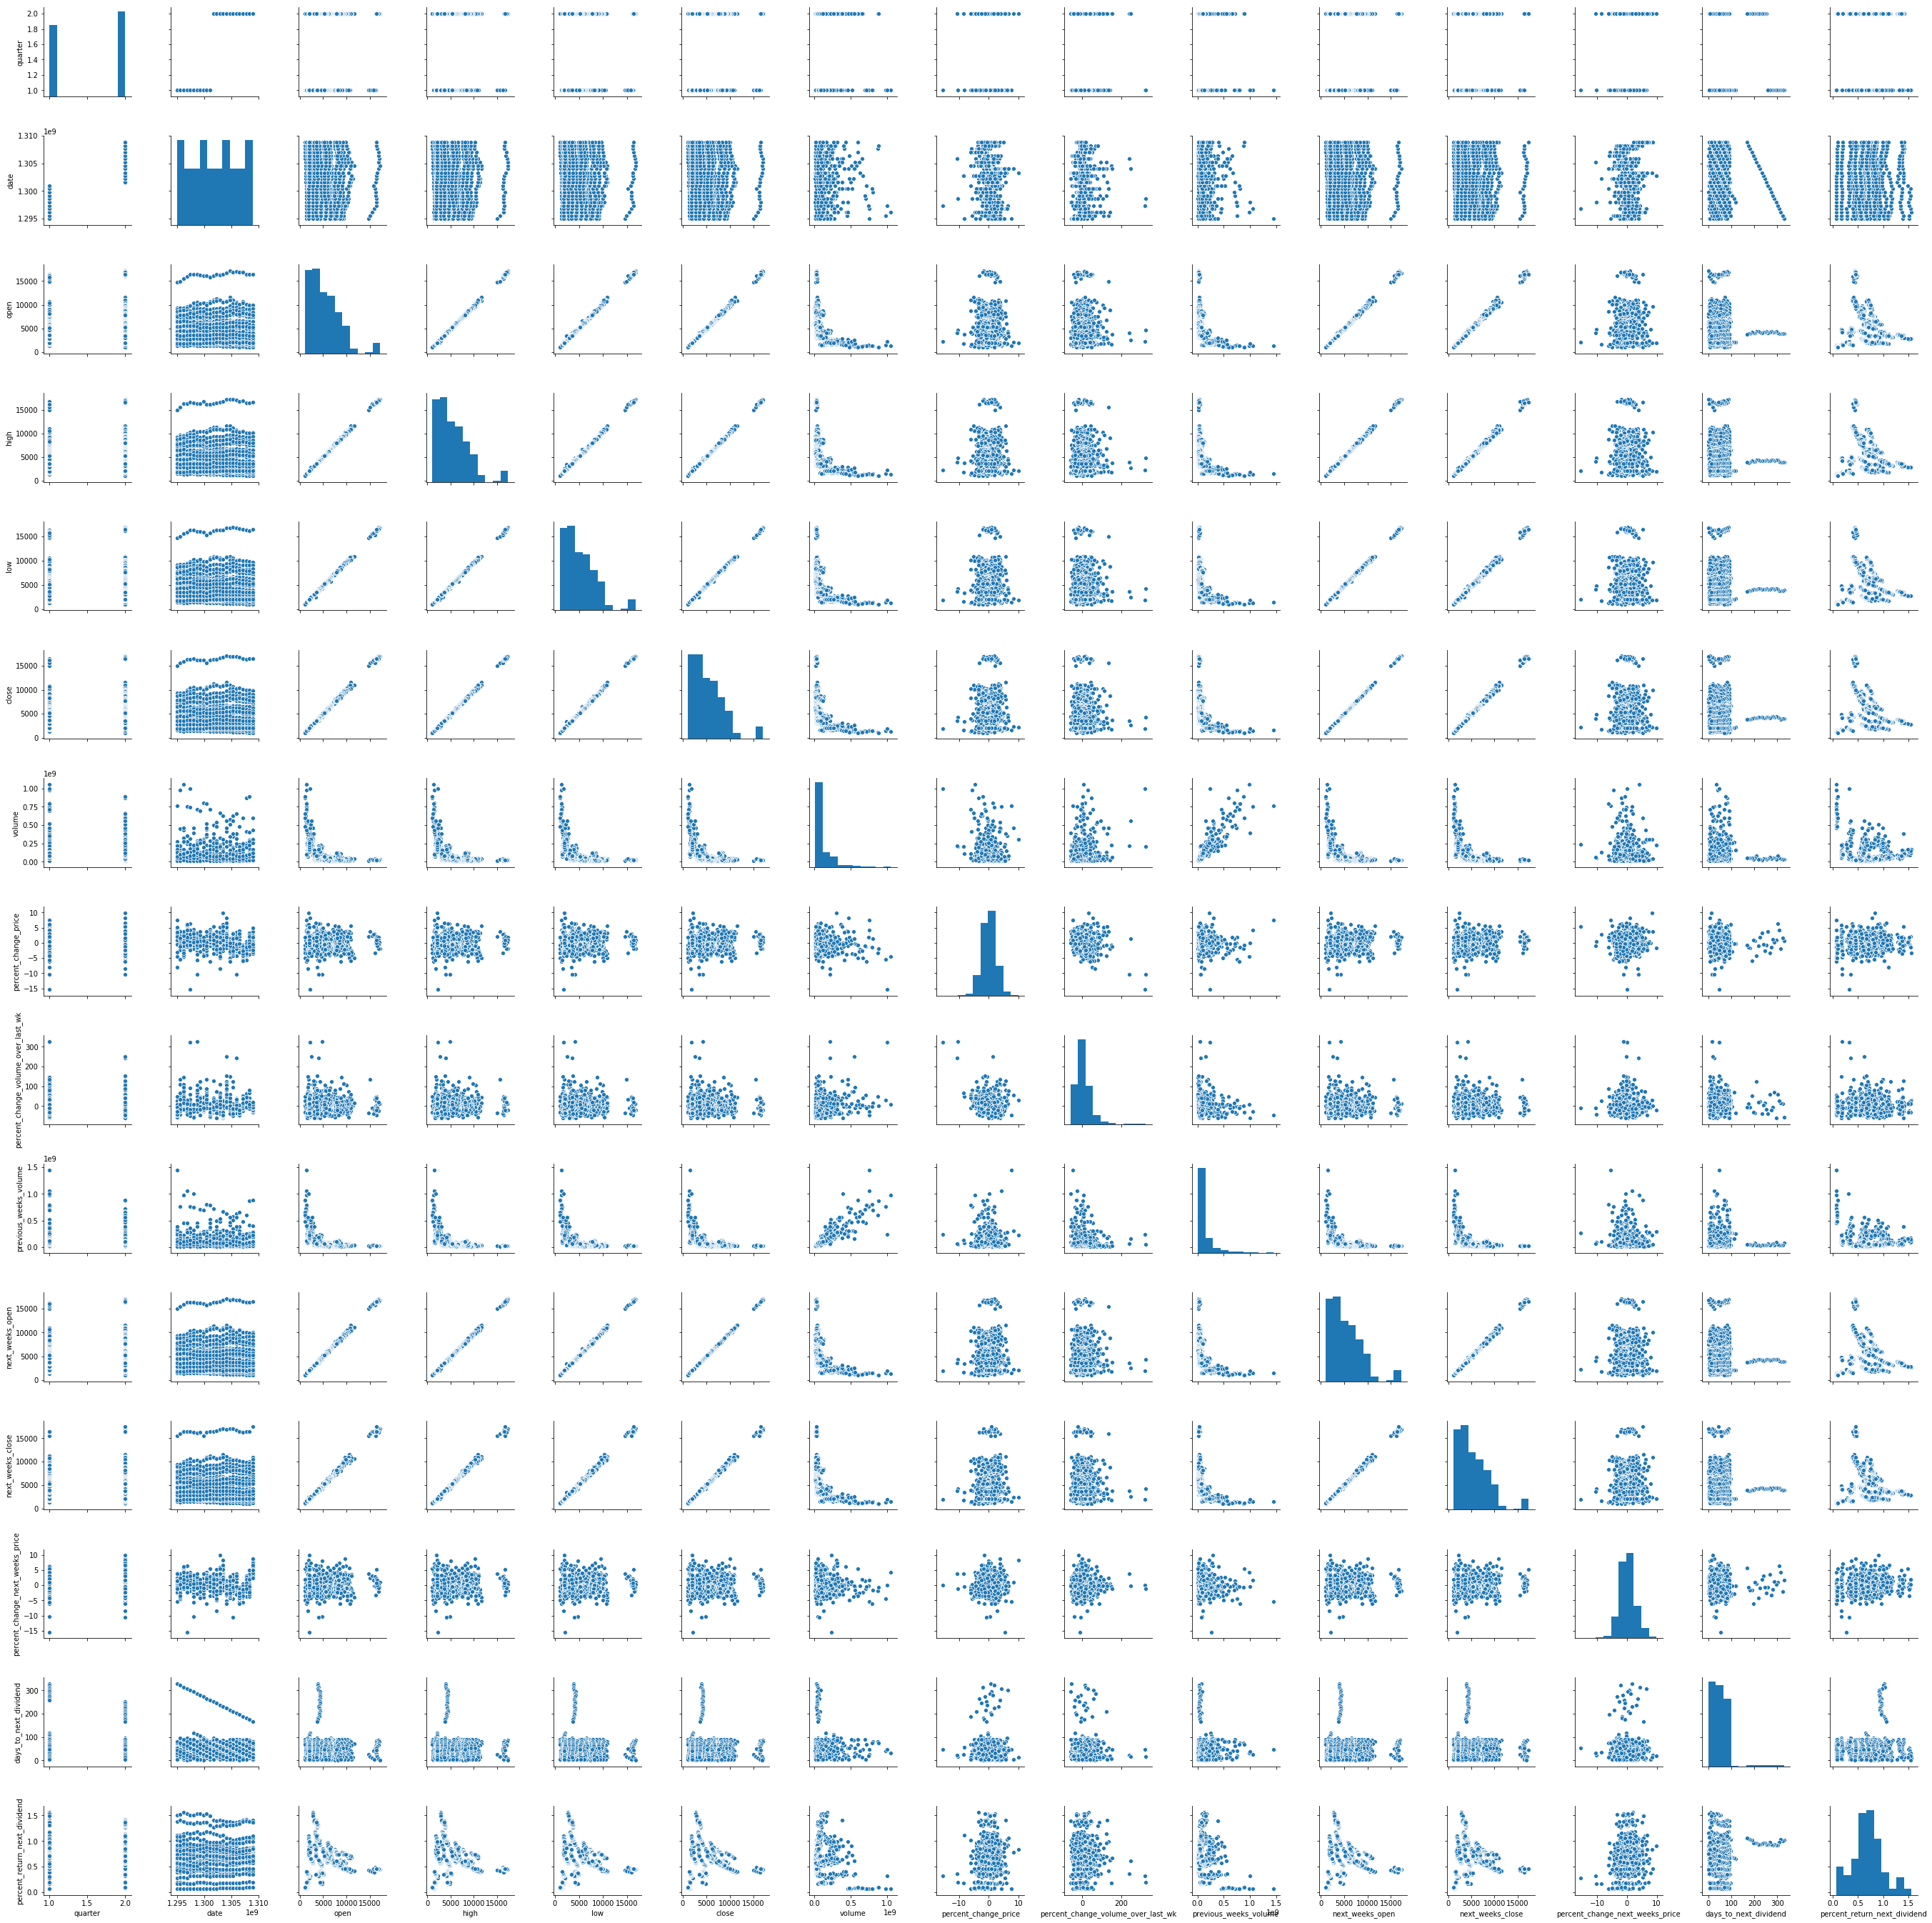

In [302]:
sns.pairplot(df_processed);

Интерес для классификации представляют графики связанные отношением `open, high, low, close, next_weeks_open, next_weeks_close` к `percent_return_next_dividend`.

Построим отдельный график `next_weeks_open - percent_return_next_dividend` и посмотрим на изначальную кластеризацию.

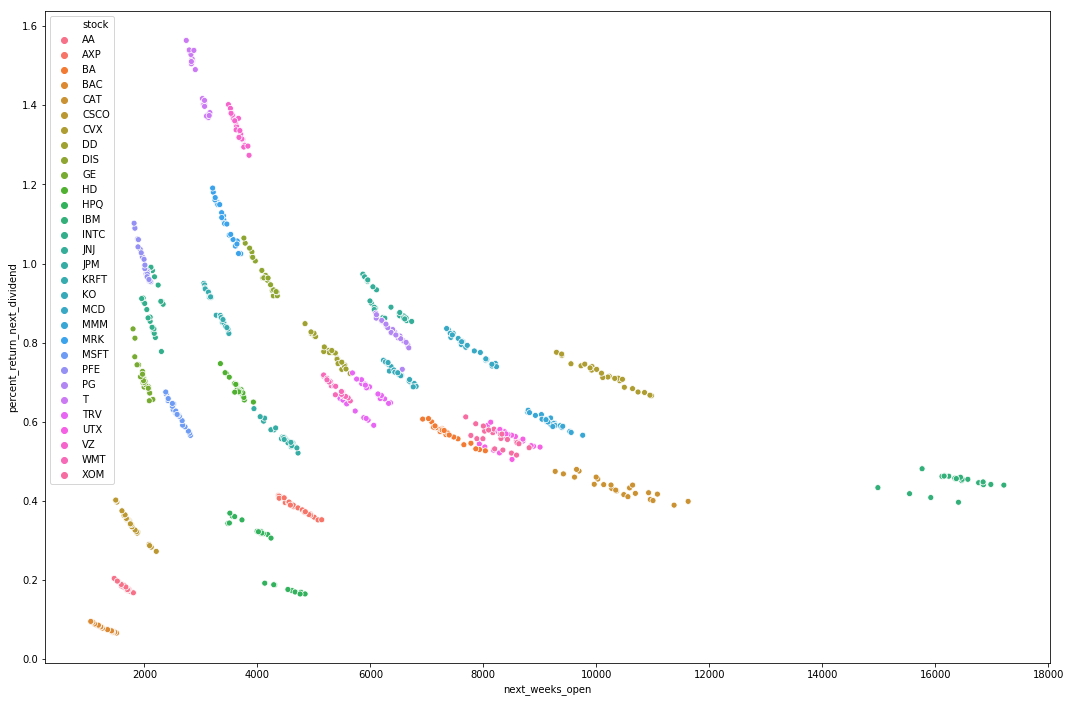

In [322]:
plt.figure(figsize=(18,12))
sns.scatterplot(x=df_processed['next_weeks_open'],y=df_processed['percent_return_next_dividend'],hue=df_target['stock']);

Ниже попробуем различными методами кластеризации приблизится к вспроизведению изначальной кластеризации.

# Методы кластеризации

## 1. Метод k-средних

In [31]:
from sklearn.cluster import KMeans

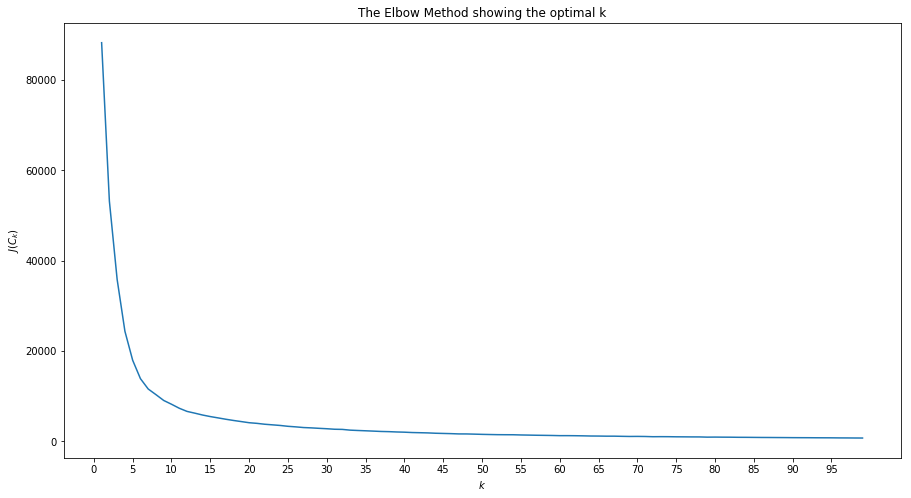

In [332]:
inertia = []
k = range(1, 100)
for cluster in k:
    km = KMeans(n_clusters=cluster)
    km.fit(df_processed[['next_weeks_open','percent_return_next_dividend']])
    inertia.append(np.sqrt(km.inertia_))

plt.figure(figsize=(15,8))
plt.plot(k, inertia)
plt.xticks(np.arange(0, 100, step=5))

plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');
plt.title('The Elbow Method showing the optimal k')
plt.show();

И графика видно, что приблезительное количество классов от 25 до 50.

Попробуем метод силуэтта.

Text(0.5, 1.0, 'The Silhouette metric showing the optimal k')

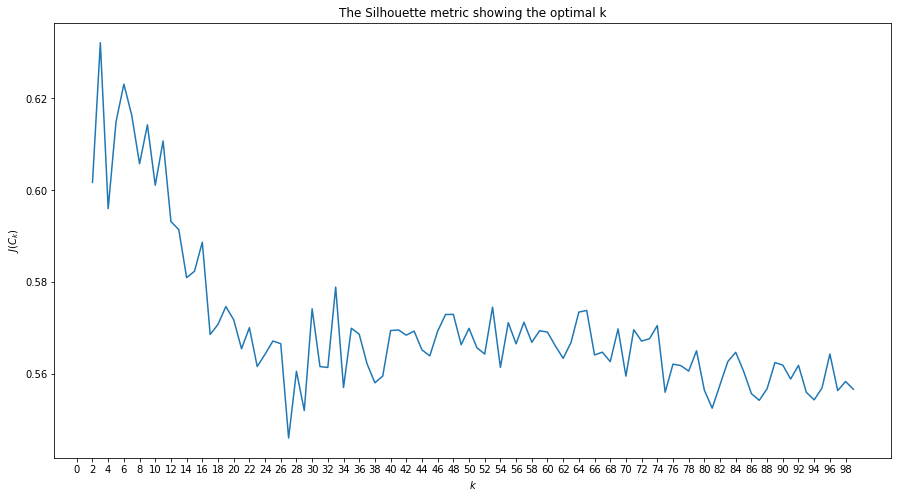

In [336]:
from sklearn.metrics import silhouette_score
inertia = []
k = range(2, 100)
for cluster in k:
    km = KMeans(n_clusters=cluster).fit(df_processed[['next_weeks_open','percent_return_next_dividend']])
    km.fit(df_processed[['next_weeks_open','percent_return_next_dividend']])
    inertia.append(silhouette_score(df_processed[['next_weeks_open','percent_return_next_dividend']], km.labels_))

plt.figure(figsize=(15,8))
plt.plot(k, inertia)
plt.xticks(np.arange(0, 100, step=2))

plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');
plt.title('The Silhouette metric showing the optimal k')

Из графика видно, что $k=27$ оптимальный.

Посчитаем меру подобия через `Rand Index`.

In [350]:
km = KMeans(n_clusters=27).fit(df_processed[['next_weeks_open','percent_return_next_dividend']])
km.fit(df_processed[['next_weeks_open','percent_return_next_dividend']])

print("ARI =", adjusted_rand_score(df_target['encoded'].values, km.labels_))

ARI = 0.41205148707491335


Посмотрим на получившуюся кластеризацию методом K-Means.

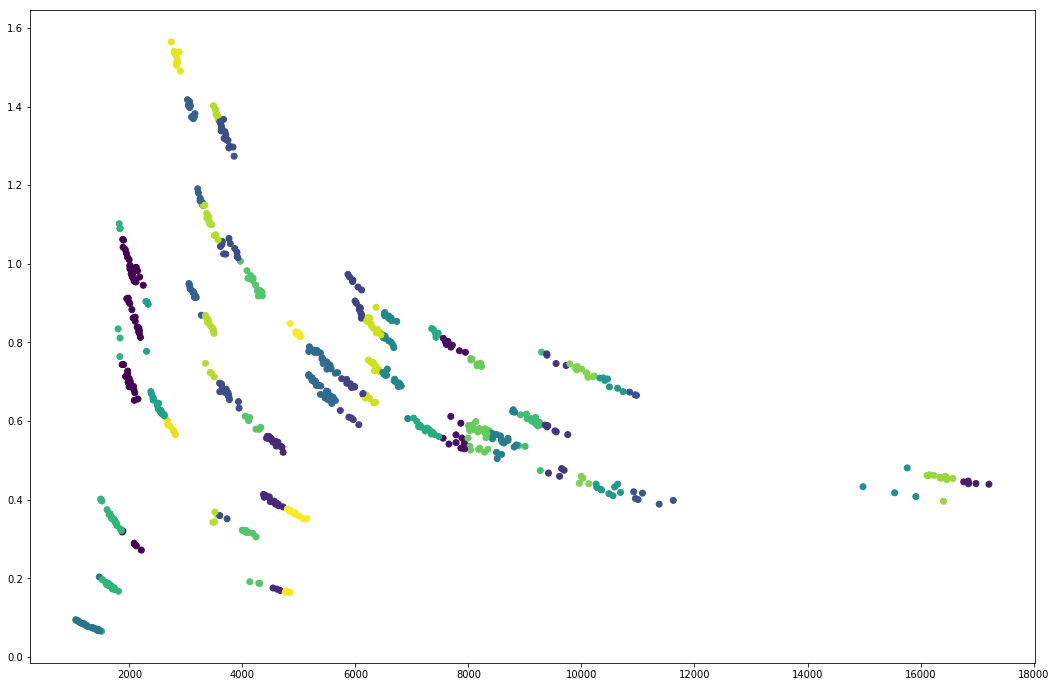

In [353]:
plt.figure(figsize=(18,12))

plt.scatter(
    x=df_processed['next_weeks_open'],
    y=df_processed['percent_return_next_dividend'],
    c=km.labels_.astype(int))
plt.show();

## 2. Иерархическая кластеризация

In [380]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

Построим дендограмму с помощью иерархии и в качестве метрики будем использовать евклидово расстояние.

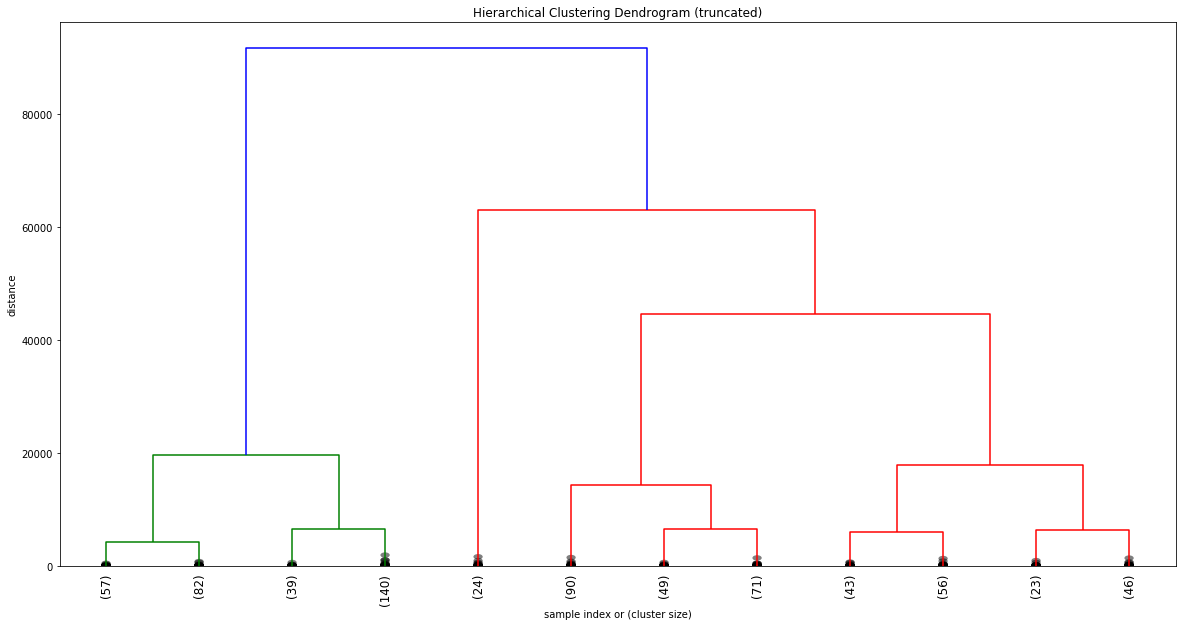

In [405]:
distance_mat = pdist(df_processed[['next_weeks_open','percent_return_next_dividend']], metric='euclidean')
Z = hierarchy.linkage(distance_mat, 'ward') 

plt.figure(figsize=(20, 10))
# выводим размеры кластеров

plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
hierarchy.dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

Иерархия нашла всего два кластера, что является плохим результатом.

## 3. Понижение размерности с методом t-SNE

Попробуем посмотреть структуру методом t-SNE. Для наглядности укажем на графике действительные кластеры.

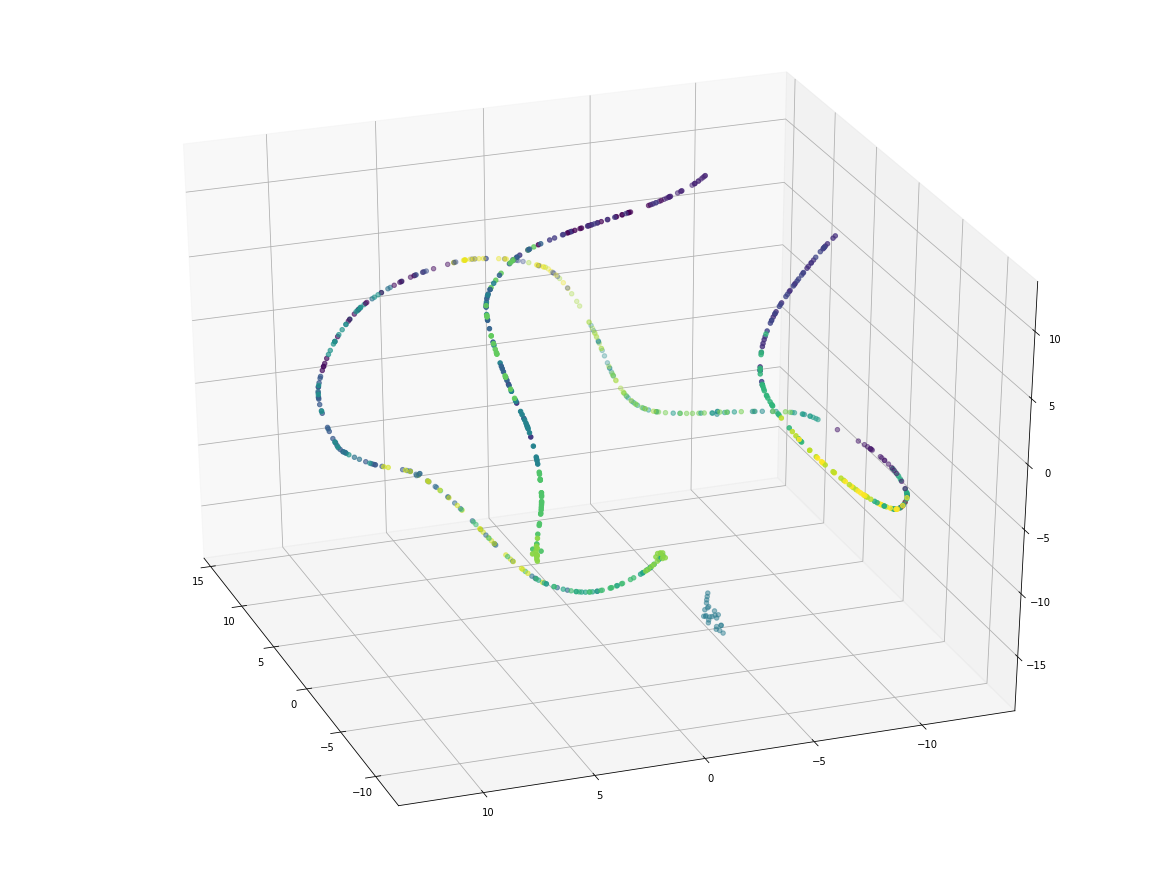

In [379]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

tsne_result = TSNE(n_components=3, perplexity=20, learning_rate=20).fit_transform(df_processed[['next_weeks_open','percent_return_next_dividend']])

fig = plt.figure(figsize=(16,12))
ax = Axes3D(fig)
ax.scatter(tsne_result[:,0], tsne_result[:, 1], tsne_result[:,2],c=df_target['encoded'])
ax.view_init(30, 160)
plt.show()

Метод t-SNE действительно находит структуру в представленных данных, но кластеры не выделил.

## 4. Метод кластеризации на основе плотности DBSCAN

Воспользуемся методом DBScan. Нам необходимо указать два пареметра: `eps` и `min_samples`. Данные подберем через цикл.

In [409]:
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

In [419]:
sc = StandardScaler()

Значение зададим так: `min_samples=5`.

Проведем сканирование через DBSCAN.

In [448]:
dbscan = DBSCAN()

X = sc.fit_transform(df_processed[['next_weeks_open','percent_return_next_dividend']])

dbscan_results = []
for eps in arange(0.005, 1, 0.005):  
    db = DBSCAN(eps=eps, min_samples=5).fit(X) #eps=0.095
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool) 
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_ 

    noise = len(labels[labels == -1])
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0) 
    dbscan_results.append((n_clusters_,eps,noise))

dbscan_results = pd.DataFrame(dbscan_results,columns=['clusters','eps','noise'])

Построим графики зависимости $eps$ от количества шума и кластеров.

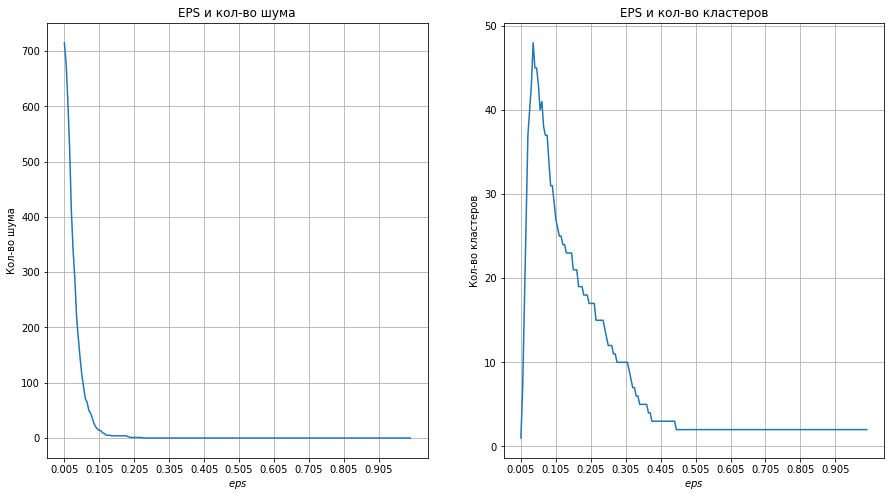

In [495]:
db = pd.DataFrame(dbscan_results,columns=['clusters','eps','noise'])

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(15,8)

axs[0].plot(dbscan_results['eps'],dbscan_results['noise'])
axs[0].set_xticks(arange(0.005, 1, 0.1))
axs[0].set_xlabel('$eps$')
axs[0].set_ylabel('Кол-во шума');
axs[0].grid(True)
axs[0].set_title('EPS и кол-во шума')


axs[1].plot(dbscan_results['eps'],dbscan_results['clusters'])
axs[1].set_xticks(arange(0.005, 1, 0.1))
axs[1].set_xlabel('$eps$')
axs[1].set_ylabel('Кол-во кластеров');
axs[1].grid(True)
axs[1].set_title('EPS и кол-во кластеров')

plt.show()

Из графика слева видно, что оптимальная точка значения $eps=0.095$ при которой происходит с ростом $eps$ шум снижается не существенно. При $eps=0.095$ количество кластеров соотвествует примерно `30`.

In [506]:
dbscan_results[dbscan_results.eps == .095]

,clusters,eps,noise
18,31,0.095,20


Из таблицы видно, что $eps=0.095$ количество кластеров соотвествует $31$. Это очень хороший результат.

Отобразим графически полученную кластеризацию.

Text(0.5, 1.0, 'Количество кластеров определенных методом DBSCAN')

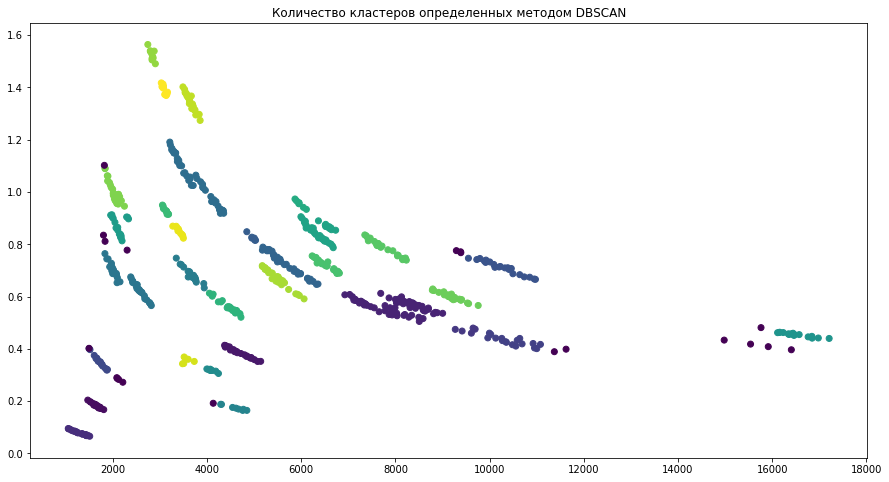

In [511]:
db = DBSCAN(eps=.095, min_samples=5).fit(X) #eps=0.095
core_samples_mask = np.zeros_like(db.labels_, dtype=bool) 
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_ 

noise = len(labels[labels == -1])
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0) 


plt.figure(figsize=(15,8))
plt.scatter(df_processed['next_weeks_open'], df_processed['percent_return_next_dividend'], c=db.labels_, marker='o')
plt.title('Количество кластеров определенных методом DBSCAN')

Посчитаем метрику ARI.

In [513]:
from sklearn.metrics.cluster import adjusted_rand_score

print("ARI =", adjusted_rand_score(df_target['encoded'], db.labels_))

ARI = 0.7031417292948268


# Выводы

Было рассмотрено четыре метода клстеризации:
1. Метод k-means
1. Иерархическая кластеризация
1. Метод t-SNE
1. Метод DBScan

Метод DBScan показал наилучшие результаты предсказав 31 кластер из дествительных 30, при этом значение метрики ARI получилось $ARI=0.70$